# Mastering Metrics Ch 2

## Regressions and Controls

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.display import display

pd.options.display.max_columns = 100

cars_data = pd.read_csv('cars_csv.csv')

display(cars_data.sample(5))

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875
90,1,128,nissan,diesel,std,two,sedan,fwd,front,94.5,165.3,63.8,54.5,2017,ohc,four,103,idi,2.99,3.47,21.9,55,4800,45,50,7099
144,0,102,subaru,gas,std,four,sedan,4wd,front,97.0,172.0,65.4,54.3,2385,ohcf,four,108,2bbl,3.62,2.64,9.0,82,4800,24,25,9233
188,2,94,volkswagen,gas,std,four,sedan,fwd,front,97.3,171.7,65.5,55.7,2300,ohc,four,109,mpfi,3.19,3.40,10.0,100,5500,26,32,9995
166,1,168,toyota,gas,std,two,hatchback,rwd,front,94.5,168.7,64.0,52.6,2300,dohc,four,98,mpfi,3.24,3.08,9.4,112,6600,26,29,9538


## Regression of Horsepower on Engine Size (cotrolling for Length)

$Y_i$ = horsepower    
$D_i$ = engine size  
$A_i$ = length

In [2]:
Y_i = 'horsepower'
D_i = 'engine-size'
A_i = 'length'


reg_data = cars_data[[Y_i, D_i, A_i]].copy()
reg_data.replace('?', np.nan, inplace = True)
reg_data = reg_data.dropna().astype(float)
reg_data.sample(5)

,horsepower,engine-size,length
87,116.0,110.0,172.4
2,154.0,152.0,171.2
30,58.0,92.0,144.6
75,175.0,140.0,178.4
71,155.0,234.0,202.6


In [3]:
#Correlations:
reg_data.corr()

,horsepower,engine-size,length
horsepower,1.000000,0.810773,0.555003
engine-size,0.810773,1.000000,0.683610
length,0.555003,0.683610,1.000000


## Run the Auxillary Regression
Regress $D_i$ on $A_i$

In [10]:
from sklearn.linear_model import LinearRegression
lr_aux = LinearRegression()
lr_aux.fit(X = reg_data.ix[:, [A_i]], 
           y = reg_data.ix[:, D_i])

reg_data['residuals'] = reg_data.ix[:, D_i].astype(float) -\
    lr_aux.predict(reg_data.ix[:, [A_i]])
    
print(lr_aux.coef_)
    
reg_data.sample(5)

[ 2.30962075]


,horsepower,engine-size,length,residuals
150,62.0,92.0,158.7,0.477779
19,70.0,90.0,155.9,4.944717
60,84.0,122.0,177.8,-13.635977
106,160.0,181.0,178.5,43.747288
109,97.0,120.0,198.9,-64.368975


## Run the Real Regression
Regress $Y_i$ on $A_i$ and the residuals of the Auxillary Regression

naive treatment effect: [ 0.76857195  0.0045168 ]
treatment effect: 0.76857195076


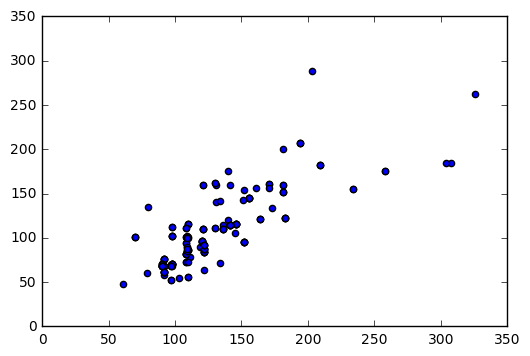

In [23]:
import matplotlib.pyplot as plt

#perform a naive regression:
lr_naive = LinearRegression()
lr_naive.fit(X = reg_data.ix[:, [D_i, A_i]], 
             y = reg_data.ix[:, Y_i])

print("naive treatment effect:", lr_naive.coef_)

#perform a regression on only the residuals:
lr_real = LinearRegression()
lr_real.fit(X = reg_data.ix[:, ['residuals']], 
            y = reg_data.ix[:, Y_i])


treatment_effect = lr_real.coef_
print("treatment effect:", treatment_effect[0])

plt.scatter(list(reg_data[D_i]), list(reg_data[Y_i]))

## Using the Omitted Variable Bias
Let's try the same but using the Omitted Variable Bias formula, and see if we get the same result.

We can integrate the controls into a monovariate linear regression (with coefficient $\beta_s$). It works like so;

Original 'long' regression:
$$Y_i = \alpha_l + \beta_l D_i + \gamma_l A_i + e_i$$
We want to convert it into a short form:
$$Y_i = \alpha_s + \beta_s D_i + e_i$$

We do so by aknowledging that:
$$\beta_s = \beta_l + \delta_A \gamma_l$$
Where $\delta_A$ is the slope from a regression of $A_i$ on $D_i$:
$$A_i = \pi_0 + \delta_A D_i + \epsilon_i$$

In [7]:
Y_i = 'horsepower'
D_i = 'engine-size'
A_i = 'length'


reg_data = cars_data[[Y_i, D_i, A_i]].copy()
reg_data.replace('?', np.nan, inplace = True)
reg_data = reg_data.dropna().astype(float)
reg_data.sample(5)

,horsepower,engine-size,length
91,69.0,97.0,165.3
180,156.0,171.0,187.8
147,94.0,108.0,173.5
115,97.0,120.0,186.7
52,68.0,91.0,159.1


In [21]:
from sklearn.linear_model import LinearRegression

#Get result from LONG regression:
lr = LinearRegression()
lr.fit(X = reg_data[[D_i, A_i]],
       y = reg_data[Y_i]
      )
print(lr.coef_)
beta_l = lr.coef_[0]
gamma_l = lr.coef_[1]

#Use a second regression to find delta_A
lr2 = LinearRegression()
lr2.fit(X = reg_data[[D_i]],
       y = reg_data[A_i]
      )
print(lr2.coef_)
delta_A = lr2.coef_[0]

#Multiply them together to get the OVB:
OVB = delta_A * gamma_l

beta_s = OVB + beta_l
print("beta_s (from OVB formula) = ", beta_s)

#Let's get beta_s the direct way too:
lr3 = LinearRegression()
lr3.fit(X = reg_data[[D_i]],
       y = reg_data[Y_i]
      )
print("beta_s (from regresssion) = ", lr3.coef_[0])

[ 0.76857195  0.0045168 ]
[ 0.20233753]
beta_s (from OVB formula) =  0.769485869655
beta_s (from regresssion) =  0.769485869655
